# Feature Engineering and Modeling

In [1]:
# import libraries
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

%matplotlib inline

In [2]:
# import datasets
cases_df = pd.read_csv('../clean_data/Cases_Normalized_per_100k.csv')
cases_df.head()

,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
0,Alameda,29.0,0.0,29,0,2020-03-18,0.019,0.008,0.055,0.123,0.795,1671329,1.735146,1.735146,0.000000,0.000000,NaN,NaN,NaN,NaN
1,Alameda,36.0,0.0,7,0,2020-03-19,0.019,0.008,0.055,0.123,0.795,1671329,2.153974,0.418828,0.000000,0.000000,NaN,NaN,NaN,NaN
2,Alameda,42.0,0.0,6,0,2020-03-20,0.019,0.008,0.055,0.123,0.795,1671329,2.512970,0.358996,0.000000,0.000000,NaN,NaN,NaN,NaN
3,Alameda,62.0,0.0,20,0,2020-03-21,0.019,0.008,0.055,0.123,0.795,1671329,3.709623,1.196652,0.000000,0.000000,NaN,NaN,NaN,NaN
4,Alameda,72.0,1.0,10,1,2020-03-22,0.019,0.008,0.055,0.123,0.795,1671329,4.307949,0.598326,0.059833,0.059833,NaN,NaN,NaN,NaN


In [3]:
cases_df.describe()

,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
count,1.812400e+04,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,1.812400e+04,18124.000000,18124.000000,18124.000000,18124.000000,17776.000000,1.777600e+04,17776.000000,17776.000000
mean,1.327444e+04,210.774443,173.013187,2.048003,0.032279,0.030699,0.063650,0.158545,0.714792,6.823606e+05,1542.530785,20.284986,19.606417,0.210988,20.232502,2.081917e-01,172.290086,2.001583
std,5.201773e+04,852.430551,814.985729,11.017366,0.028533,0.026178,0.033898,0.040410,0.092762,1.456208e+06,2084.332897,43.944282,28.624650,0.831238,31.417552,4.040341e-01,775.800926,9.438015
min,0.000000e+00,0.000000,-1157.000000,-16.000000,0.001000,0.000000,0.004000,0.058000,0.482000,1.129000e+03,0.000000,-74.546183,0.000000,-5.543545,-6.977150,-7.919349e-01,-1.142857,-1.428571
25%,9.400000e+01,1.000000,1.000000,0.000000,0.015000,0.013000,0.040000,0.134000,0.661000,4.590500e+04,99.646385,0.606875,1.002456,0.000000,2.049615,1.522592e-15,2.000000,0.000000
50%,1.044000e+03,15.000000,14.000000,0.000000,0.023000,0.023000,0.058000,0.156000,0.737000,1.928430e+05,711.532789,6.700781,8.138623,0.000000,8.310360,5.983262e-02,18.285714,0.142857
75%,8.147250e+03,114.000000,85.000000,0.000000,0.043000,0.043000,0.084000,0.186000,0.786000,7.621480e+05,2248.121154,22.165620,27.829294,0.000000,24.251025,2.301092e-01,89.464286,1.000000
max,1.048757e+06,15260.000000,28549.000000,318.000000,0.140000,0.135000,0.162000,0.276000,0.889000,1.003911e+07,15791.711641,1860.053144,272.052534,27.717723,566.793296,6.335479e+00,15711.142857,241.285714


In [4]:
# convert date to datetime
cases_df['date'] = pd.to_datetime(cases_df['date'])

In [5]:
# drop no longer needed columns
cases_df.drop(['totalcountconfirmed', 'totalcountdeaths', 'newcountconfirmed',
              'newcountdeaths', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 
              'ALWAYS', 'deathper100k', 'newdeath100k', 'confirmedper100k', 'population',
               'newlyconfirmedper100k' ,'7dayrollingavg_newlyconfirmed_rawnumber', '7dayrollingavg_newdeath_rawnumber'], 
             axis = 1, inplace = True)
cases_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath
0,Alameda,2020-03-18,NaN,NaN
1,Alameda,2020-03-19,NaN,NaN
2,Alameda,2020-03-20,NaN,NaN
3,Alameda,2020-03-21,NaN,NaN
4,Alameda,2020-03-22,NaN,NaN


In [6]:
# bring in hospital data
hospitals_df = pd.read_csv('../clean_data/hospitals_by_county.csv')
hospitals_df.head()

,county,todays_date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
0,Plumas,2020-03-29,0.0,1.0,1.0,NaN,0.0,1.0,NaN
1,Tehama,2020-03-29,0.0,0.0,0.0,308.0,0.0,0.0,2.0
2,Glenn,2020-03-29,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,Mono,2020-03-29,0.0,1.0,1.0,308.0,0.0,0.0,2.0
4,Marin,2020-03-29,7.0,13.0,20.0,493.0,2.0,6.0,11.0


In [7]:
# convert to datetime
hospitals_df['todays_date'] = pd.to_datetime(hospitals_df['todays_date'])

In [8]:
# drop unncessary columns
hospitals_df.drop(['hospitalized_covid_confirmed_patients', 'hospitalized_suspected_covid_patients', 
                   'icu_covid_confirmed_patients', 'icu_suspected_covid_patients'],
                 axis = 1, inplace = True)
hospitals_df.head()

,county,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Plumas,2020-03-29,1.0,NaN,NaN
1,Tehama,2020-03-29,0.0,308.0,2.0
2,Glenn,2020-03-29,0.0,NaN,NaN
3,Mono,2020-03-29,1.0,308.0,2.0
4,Marin,2020-03-29,20.0,493.0,11.0


In [9]:
cases_hosp_df = cases_df.merge(hospitals_df, how = 'inner', left_on = ['county','date'], right_on = ['county', 'todays_date'])
cases_hosp_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Alameda,2020-03-29,1.153915,0.042738,2020-03-29,127.0,2725.0,119.0
1,Alameda,2020-03-30,1.384698,0.051285,2020-03-30,148.0,3283.0,146.0
2,Alameda,2020-03-31,1.478721,0.042738,2020-03-31,150.0,1857.0,77.0
3,Alameda,2020-04-01,1.307770,0.042738,2020-04-01,128.0,2456.0,106.0
4,Alameda,2020-04-02,1.478721,0.051285,2020-04-02,133.0,2580.0,112.0


In [10]:
# do a group by so we can create predictions per county
county_df = cases_hosp_df.groupby(['county', 'date']).mean()

In [11]:
county_df.index.get_level_values('county').unique()[0]

'Alameda'

In [12]:
# start by analyzing LA County
county_df.loc['Los Angeles']

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
date,,,,,
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0
...,...,...,...,...,...
2021-01-20,110.458032,2.033476,7413.0,19392.0,236.0
2021-01-21,97.337912,2.002170,7226.0,19411.0,274.0
2021-01-22,88.508157,1.999324,7014.0,19377.0,281.0


In [13]:
county_df.loc['Los Angeles']

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
date,,,,,
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0
...,...,...,...,...,...
2021-01-20,110.458032,2.033476,7413.0,19392.0,236.0
2021-01-21,97.337912,2.002170,7226.0,19411.0,274.0
2021-01-22,88.508157,1.999324,7014.0,19377.0,281.0


In [14]:
county_df.to_csv('../clean_data/counties_models.csv')

In [15]:
la_df = county_df.loc['Los Angeles']
features = ['hospitalized_covid_patients']
X = la_df[features]
y = la_df[['7dayrollingavg_newlyconfirmed']].values

In [16]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.15)

In [17]:
# scale our data
mms = MinMaxScaler()
X_train_sc = mms.fit_transform(X_train)
X_test_sc = mms.transform(X_test)

In [18]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 1,  batch_size = 32)

In [19]:
# Create test sequences
batch_x, batch_y = train_sequences[0]

In [20]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 1,  batch_size = 32)

In [21]:
input_shape = train_sequences[0][0][0].shape

In [22]:
# Design RNN
model = Sequential()
model.add(LSTM(128, input_shape = (input_shape), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'swish', kernel_regularizer = l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'swish', kernel_regularizer = l2(0.001)))
model.add(Dense(1))

In [23]:
model.compile(optimizer=Adam(lr = 0.005), loss = 'mae')
early_stop = EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1, mode = 'auto')

In [24]:
history = model.fit(train_sequences, validation_data = (test_sequences), epochs = 200, verbose = 0,callbacks = [early_stop] )

Epoch 00178: early stopping


In [25]:
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

6.307078838348389
14.0885009765625


In [26]:
preds_train = model.predict(train_sequences)

In [27]:
preds_train.shape

(255, 1, 1)

In [28]:
train_preds = preds_train[:,0]

In [29]:
train_preds = train_preds.reshape(255)

In [30]:
preds_test = model.predict(test_sequences)

In [31]:
preds_test.shape

(45, 1, 1)

In [32]:
test_preds = preds_test[:, 0]
test_preds = test_preds.reshape(45)

In [33]:
test_preds.shape

(45,)

In [34]:
len(history.history['loss'])

178

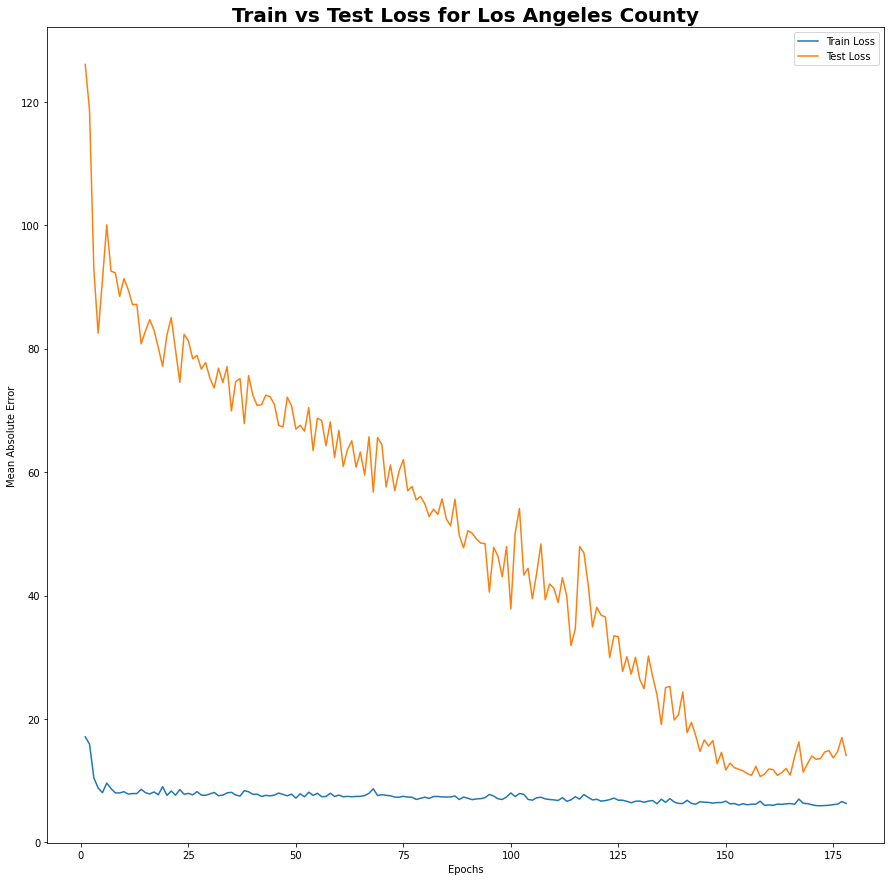

In [36]:
plt.figure(figsize=(15,15))
sns.lineplot(x = range(1, 179), y = history.history['loss'], label = 'Train Loss')
sns.lineplot(x = range(1, 179), y = history.history['val_loss'], label = 'Test Loss')
plt.title('Train vs Test Loss for Los Angeles County', fontsize = 20, fontweight = 'bold')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('../images/train_test_loss_la_county.png');

In [37]:
# generate predictions
future_pred_count = 1
future = []
batch = X_test_sc[-future_pred_count:].reshape((1, future_pred_count, 1))
model.predict(batch)[0].shape

for i in range(22):
    pred = model.predict(batch)[0]
    future.append(pred)
    batch = np.append(batch[:, 0:, :], [[pred[i]]] , axis = 1)

In [38]:
dates = [la_df.index[-1] + pd.tseries.offsets.DateOffset(days = x) for x in range(0, 23)]
future_date = pd.DataFrame(index = dates[1:], columns = X.columns)
future_date.tail()

,hospitalized_covid_patients
2021-02-11,NaN
2021-02-12,NaN
2021-02-13,NaN
2021-02-14,NaN
2021-02-15,NaN


In [39]:
df_predict = pd.DataFrame(future[21], index = future_date[-22:].index, columns = ['Prediction'])
df_predict.head()

,Prediction
2021-01-25,124.042221
2021-01-26,151.087616
2021-01-27,156.737381
2021-01-28,158.268784
2021-01-29,158.790863


In [40]:
df_test = pd.concat([la_df, df_predict], axis = 1)
df_test

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0,NaN
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0,NaN
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0,NaN
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0,NaN
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0,NaN
...,...,...,...,...,...,...
2021-02-11,NaN,NaN,NaN,NaN,NaN,159.253693
2021-02-12,NaN,NaN,NaN,NaN,NaN,159.253693
2021-02-13,NaN,NaN,NaN,NaN,NaN,159.253693
2021-02-14,NaN,NaN,NaN,NaN,NaN,159.253693


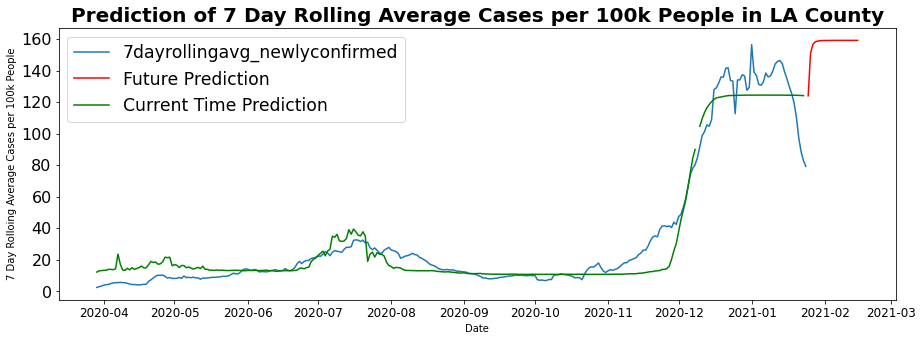

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(df_test.index, df_test['7dayrollingavg_newlyconfirmed'])
plt.plot(df_test.index, df_test['Prediction'], color = 'r')
plt.plot(X_train.index[:-1], train_preds, color = 'g')
plt.plot(X_test.index[:-1], test_preds, color = 'g')
plt.legend(['7dayrollingavg_newlyconfirmed', 'Future Prediction', 'Current Time Prediction'], loc = 'best', fontsize = 'xx-large')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 16)
plt.xlabel('Date')
plt.ylabel('7 Day Rolloing Average Cases per 100k People')
plt.title('Prediction of 7 Day Rolling Average Cases per 100k People in LA County', fontsize = 20, fontweight = 'bold')
plt.savefig('../images/rolling_7_day_prediction.png');

In [42]:
# create a function to generate predictions for every county
def pred_model(df):
    X = df[['hospitalized_covid_patients']]
    y = df[['7dayrollingavg_newlyconfirmed']].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.4)
    mms = MinMaxScaler() # use MinMaxScaler as we are dealing with purely positive values
    X_train_sc = mms.fit_transform(X_train)
    X_test_sc = mms.transform(X_test)
    
    # Create training sequences
    train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 1,  batch_size = 128)
    
    # Create test sequences
    batch_x, batch_y = train_sequences[0]
    test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 1,  batch_size = 128)
    input_shape = train_sequences[0][0][0].shape
    
    # Design RNN
    model = Sequential()
    model.add(LSTM(60, input_shape = (input_shape), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation = 'swish', kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation = 'swish', kernel_regularizer = l2(0.001)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr = 0.005), loss = 'mae')
    early_stop = EarlyStopping(monitor = 'val_loss', patience = 100, verbose = 1, mode = 'auto')
    model.fit(train_sequences, validation_data = (test_sequences), epochs = 1000, verbose = 0, callbacks = [early_stop])
    
    future_pred_count = 1
    future = []
    batch = X_test_sc[-future_pred_count:].reshape((1, future_pred_count, 1))
    model.predict(batch)[0].shape

    for i in range(22):
        pred = model.predict(batch)[0]
        future.append(pred)
        batch = np.append(batch[:, 0:, :], [[pred[i]]] , axis = 1)
        
    dates = [la_df.index[-1] + pd.tseries.offsets.DateOffset(days = x) for x in range(0, 22)]
    future_date = pd.DataFrame(index = dates[1:], columns = X.columns)
    future_date.head()
    
    df_predict = pd.DataFrame(future[20], index = future_date[-21:].index, columns = ['Prediction'])
    df_test = pd.concat([df, df_predict], axis = 1)
    
    return df_test, model

In [43]:
county_df.index.get_level_values('county').unique()

Index(['Alameda', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa',
       'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial',
       'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera',
       'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey',
       'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside',
       'Sacramento', 'San Benito', 'San Bernardino', 'San Diego',
       'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo',
       'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Siskiyou',
       'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity',
       'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba'],
      dtype='object', name='county')

In [57]:
# generate predictions for all 58 counties
todays_date = datetime.datetime.now().date()
index = pd.date_range(todays_date-datetime.timedelta(400), periods = 1, freq = 'D')
pred_df = pd.DataFrame(index = index, columns = df_test.columns)

for i in county_df.index.get_level_values('county').unique():
    model_df = county_df.loc[i]
    prediction_df, model = pred_model(model_df)
    model.save(f'./county_models/{i}.h5', save_format='h5')
    prediction_df['County'] = i
    pred_df = pred_df.append(prediction_df)
    
pred_df.head()

Epoch 00151: early stopping


Epoch 00149: early stopping


Epoch 00167: early stopping


Epoch 00243: early stopping


Epoch 00162: early stopping


Epoch 00194: early stopping


Epoch 00240: early stopping


Epoch 00121: early stopping


Epoch 00141: early stopping


Epoch 00122: early stopping


Epoch 00114: early stopping


Epoch 00186: early stopping


Epoch 00118: early stopping


Epoch 00538: early stopping


Epoch 00189: early stopping


Epoch 00126: early stopping


Epoch 00125: early stopping


Epoch 00514: early stopping


Epoch 00142: early stopping


Epoch 00151: early stopping


Epoch 00121: early stopping


Epoch 00177: early stopping


Epoch 00150: early stopping


Epoch 00100: early stopping


Epoch 00116: early stopping


Epoch 00172: early stopping


Epoch 00192: early stopping


Epoch 00119: early stopping


Epoch 00378: early stopping


Epoch 00148: early stopping


Epoch 00118: early stopping


Epoch 00354: early stopping


Epoch 00165: early stopping


Epoch 00180: early stopping


Epoch 00158: early stopping


Epoch 00124: early stopping


Epoch 00120: early stopping


Epoch 00140: early stopping


Epoch 00174: early stopping


Epoch 00121: early stopping


Epoch 00293: early stopping


Epoch 00174: early stopping


Epoch 00162: early stopping


Epoch 00153: early stopping


Epoch 00120: early stopping


Epoch 00156: early stopping


Epoch 00198: early stopping


Epoch 00203: early stopping


Epoch 00130: early stopping


Epoch 00182: early stopping


Epoch 00105: early stopping


Epoch 00157: early stopping


Epoch 00235: early stopping


Epoch 00164: early stopping


Epoch 00156: early stopping


Epoch 00150: early stopping


,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction,County
2019-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29,1.153915,0.042738,127.0,2725.0,119.0,NaN,Alameda
2020-03-30,1.384698,0.051285,148.0,3283.0,146.0,NaN,Alameda
2020-03-31,1.478721,0.042738,150.0,1857.0,77.0,NaN,Alameda
2020-04-01,1.307770,0.042738,128.0,2456.0,106.0,NaN,Alameda


In [47]:
pred_df.tail()

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction,County
2021-02-10,NaN,NaN,NaN,NaN,NaN,30.755768,Yuba
2021-02-11,NaN,NaN,NaN,NaN,NaN,30.755768,Yuba
2021-02-12,NaN,NaN,NaN,NaN,NaN,30.756201,Yuba
2021-02-13,NaN,NaN,NaN,NaN,NaN,30.756201,Yuba
2021-02-14,NaN,NaN,NaN,NaN,NaN,30.756201,Yuba


In [48]:
pred_df.drop(index = pred_df.index[0], axis = 0, inplace = True)

In [49]:
pred_df['7dayrollingavg_newlyconfirmed'].fillna(pred_df['Prediction'], inplace = True)

In [50]:
pred_df.head()

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction,County
2020-03-29,1.153915,0.042738,127.0,2725.0,119.0,NaN,Alameda
2020-03-30,1.384698,0.051285,148.0,3283.0,146.0,NaN,Alameda
2020-03-31,1.478721,0.042738,150.0,1857.0,77.0,NaN,Alameda
2020-04-01,1.307770,0.042738,128.0,2456.0,106.0,NaN,Alameda
2020-04-02,1.478721,0.051285,133.0,2580.0,112.0,NaN,Alameda


In [51]:
pred_df[pred_df['County'] == 'San Francisco'][300:340]

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction,County
2021-01-23,23.578626,0.388926,201.0,2133.0,49.0,NaN,San Francisco
2021-01-24,23.011443,0.632004,197.0,2103.0,57.0,NaN,San Francisco
2021-01-25,11.260606,NaN,NaN,NaN,NaN,11.260606,San Francisco
2021-01-26,23.028988,NaN,NaN,NaN,NaN,23.028988,San Francisco
2021-01-27,25.084200,NaN,NaN,NaN,NaN,25.084200,San Francisco
2021-01-28,25.530523,NaN,NaN,NaN,NaN,25.530523,San Francisco
2021-01-29,25.666498,NaN,NaN,NaN,NaN,25.666498,San Francisco
2021-01-30,25.718714,NaN,NaN,NaN,NaN,25.718714,San Francisco
2021-01-31,25.743866,NaN,NaN,NaN,NaN,25.743866,San Francisco
2021-02-01,25.756575,NaN,NaN,NaN,NaN,25.756575,San Francisco


In [52]:
export_df = pred_df[['7dayrollingavg_newlyconfirmed', 'County']]
export_df.head()

,7dayrollingavg_newlyconfirmed,County
2020-03-29,1.153915,Alameda
2020-03-30,1.384698,Alameda
2020-03-31,1.478721,Alameda
2020-04-01,1.307770,Alameda
2020-04-02,1.478721,Alameda


In [53]:
export_df.to_csv('../clean_data/predictions.csv')

In [54]:
new_model = load_model('./county_models/Alameda/')

In [55]:
future_pred_count = 1
future = []
batch = X_test_sc[-future_pred_count:].reshape((1, future_pred_count, 1))
new_model.predict(batch)[0].shape

for i in range(22):
    pred = new_model.predict(batch)[0]
    future.append(pred)
    batch = np.append(batch[:, 0:, :], [[pred[i]]] , axis = 1)
        
dates = [la_df.index[-1] + pd.tseries.offsets.DateOffset(days = x) for x in range(0, 22)]
future_date = pd.DataFrame(index = dates[1:], columns = X.columns)
future_date.head()
    
df_predict = pd.DataFrame(future[20], index = future_date[-21:].index, columns = ['Prediction'])
df_test = pd.concat([la_df, df_predict], axis = 1)

In [56]:
df_test

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0,NaN
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0,NaN
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0,NaN
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0,NaN
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0,NaN
...,...,...,...,...,...,...
2021-02-10,NaN,NaN,NaN,NaN,NaN,25.962629
2021-02-11,NaN,NaN,NaN,NaN,NaN,25.962629
2021-02-12,NaN,NaN,NaN,NaN,NaN,25.962629
2021-02-13,NaN,NaN,NaN,NaN,NaN,25.962629
